In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

In [7]:
import warnings 
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("nat_gas.csv")

In [9]:
df.columns

Index(['Dates', 'Prices'], dtype='object')

In [10]:
df["Dates"] = pd.to_datetime(df["Dates"])
df = df.set_index("Dates").asfreq("M") 

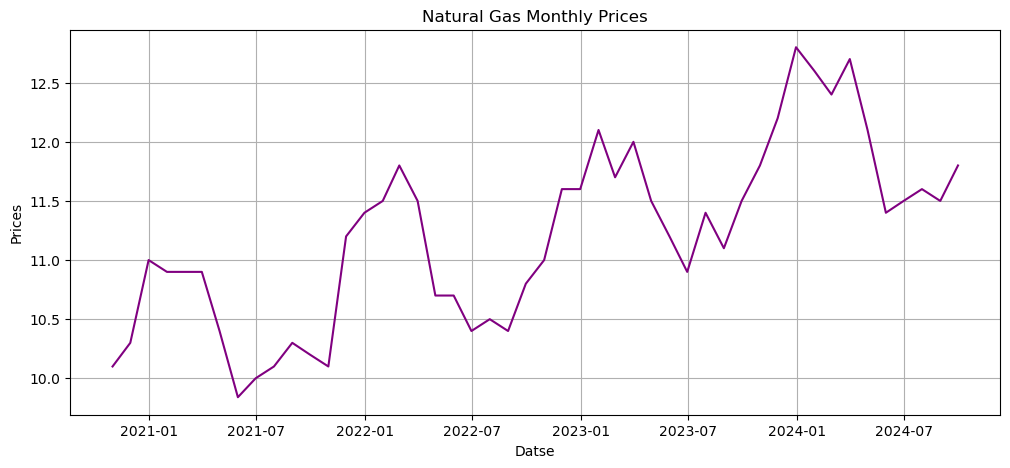

In [13]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Prices"], color='Purple')
plt.title("Natural Gas Monthly Prices")
plt.xlabel("Datse")
plt.ylabel("Prices")
plt.grid(True)
plt.show()

In [15]:
model = SARIMAX(
    df["Prices"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   1.581
Date:                            Fri, 12 Dec 2025   AIC                              6.838
Time:                                    12:17:35   BIC                             12.061
Sample:                                10-31-2020   HQIC                             7.972
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4533      0.301     -1.505      0.132      -1.044       0.137
ma.L1         -0.5152      0.344   

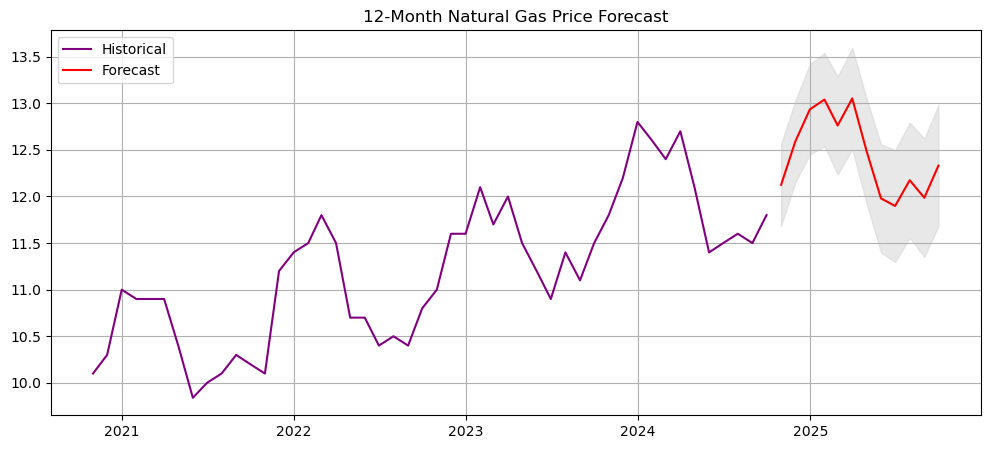

In [18]:
forecast = results.get_forecast(steps=12)
forecast_df = forecast.summary_frame()

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Prices"], label="Historical",color='Purple')
plt.plot(forecast_df.index, forecast_df["mean"], label="Forecast",color='Red')
plt.fill_between(
    forecast_df.index,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    color="lightgray",
    alpha=0.5
)
plt.title("12-Month Natural Gas Price Forecast")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
def nearest_index(index, target_date):
    idx_array = index.values.astype('datetime64[ns]')
    target = np.datetime64(target_date)
    nearest_idx = np.argmin(np.abs(idx_array - target))
    return index[nearest_idx]

In [25]:
def estimate_price(date_str):
    date = pd.to_datetime(date_str)

    # If inside historical data
    if date <= df.index[-1]:
        closest_date = nearest_index(df.index, date)
        return float(df.loc[closest_date, price_col])

    # If inside 12-month forecast window
    if date <= forecast_df.index[-1]:
        closest_date = nearest_index(forecast_df.index, date)
        return float(forecast_df.loc[closest_date, "mean"])

    raise ValueError("Date is outside the allowed 1-year forecast range.")

In [27]:
price_col = "Prices"

In [28]:
print("Estimated price on 2023-07-15:", estimate_price("2023-07-15"))
print("Estimated price on 2025-02-01:", estimate_price("2025-02-01"))

Estimated price on 2023-07-15: 10.9
Estimated price on 2025-02-01: 13.039950312613263
